# load data

In [2]:
import pandas as pd
import os
from rich.console import Console
from rich.table import Table
from sklearn.preprocessing import StandardScaler

# 定義基礎路徑和文件路徑
# Directory path
base_path = 'data/2019'

# List of training file paths
file_paths = [
    os.path.join(base_path, 'LDAP-training.parquet'),
    os.path.join(base_path, 'MSSQL-training.parquet'),
    os.path.join(base_path, 'NetBIOS-training.parquet'),
    os.path.join(base_path, 'Portmap-training.parquet'),
    os.path.join(base_path, 'Syn-training.parquet'),
    os.path.join(base_path, 'UDP-training.parquet'),
    os.path.join(base_path, 'UDPLag-training.parquet'),
    
    os.path.join(base_path, 'DNS-testing.parquet'),
    os.path.join(base_path, 'LDAP-testing.parquet'),
    os.path.join(base_path, 'MSSQL-testing.parquet'),
    os.path.join(base_path, 'NetBIOS-testing.parquet'),
    os.path.join(base_path, 'NTP-testing.parquet'),
    os.path.join(base_path, 'SNMP-testing.parquet'),
    os.path.join(base_path, 'Syn-testing.parquet'),
    os.path.join(base_path, 'TFTP-testing.parquet'),
    os.path.join(base_path, 'UDP-testing.parquet'),
    os.path.join(base_path, 'UDPLag-testing.parquet')
]

# Read and concatenate all Parquet training files into a single DataFrame
dfs = [pd.read_parquet(file_path) for file_path in file_paths]
df_combined = pd.concat(dfs, ignore_index=True)


# 保留原始數據副本（若需要對比）
df_original = df_combined.copy()

# 去除列名中的前後空格
df_combined.columns = df_combined.columns.str.strip()

# 如果存在 'Label' 列，將非 'Benign' 的值替換為 'DDoS'
if 'Label' in df_combined.columns:
    df_combined['Label'] = df_combined['Label'].apply(lambda x: 'DDoS' if x != 'Benign' else x)



# 使用 rich 庫創建並顯示列名表格
console = Console()
table = Table(show_header=True, header_style="bold magenta")
table.add_column("索引", style="dim", justify="left")
table.add_column("列名", style="dim", justify="left")
    
for idx, col in enumerate(df_combined.columns):
    table.add_row(str(idx), col)

console.print(table)

# 特徵工程：創建新特徵
df_combined['PSH Flags Ratio'] = df_combined['Fwd PSH Flags'] / (df_combined['Bwd PSH Flags'] + 1e-6)
df_combined['Flow Packets/Bytes Ratio'] = df_combined['Flow Packets/s'] / (df_combined['Flow Bytes/s'] + 1e-6)
df_combined['Total Packets'] = df_combined['Total Fwd Packets'] + df_combined['Total Backward Packets']
df_combined['Active-Idle Mean Difference'] = df_combined['Active Mean'] - df_combined['Idle Mean']

# 選定用於後續處理的特徵
entropy_features = [
    "Protocol",                   # 協議類型
    "Flow Duration",              # 連接持續時間
    "Flow Bytes/s",               # 流量大小（比特率）
    "Flow Packets/Bytes Ratio",   # Flow Packets/s 和 Flow Bytes/s 比值
    "Total Packets",              # 合併 Total Fwd Packets 和 Total Backward Packets
    "Flow IAT Mean",              # 流的到達時間均值
    "PSH Flags Ratio",            # 數據包推送標誌比值
    "Active-Idle Mean Difference" # 活躍與空閒時間均值差異
]

# 使用 StandardScaler 對選定特徵進行標準化
scaler = StandardScaler()
df_combined[entropy_features] = scaler.fit_transform(df_combined[entropy_features])


print(len(df_combined))

print(df_combined['Label'].unique())


┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 索引 ┃ 列名                     ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0    │ Protocol                 │
│ 1    │ Flow Duration            │
│ 2    │ Total Fwd Packets        │
│ 3    │ Total Backward Packets   │
│ 4    │ Fwd Packets Length Total │
│ 5    │ Bwd Packets Length Total │
│ 6    │ Fwd Packet Length Max    │
│ 7    │ Fwd Packet Length Min    │
│ 8    │ Fwd Packet Length Mean   │
│ 9    │ Fwd Packet Length Std    │
│ 10   │ Bwd Packet Length Max    │
│ 11   │ Bwd Packet Length Min    │
│ 12   │ Bwd Packet Length Mean   │
│ 13   │ Bwd Packet Length Std    │
│ 14   │ Flow Bytes/s             │
│ 15   │ Flow Packets/s           │
│ 16   │ Flow IAT Mean            │
│ 17   │ Flow IAT Std             │
│ 18   │ Flow IAT Max             │
│ 19   │ Flow IAT Min             │
│ 20   │ Fwd IAT Total            │
│ 21   │ Fwd IAT Mean             │
│ 22   │ Fwd IAT Std              │
│ 23   │ Fwd IAT Max              │
│ 24   │ Fwd IAT Min              │
│ 25   │ Bwd IAT Total            │
│ 26   │ Bwd IAT Mean             │
│ 27   │ Bwd IAT Std              │
│ 28   │ Bwd IAT Max              │
│ 29   │ Bwd IAT Min              │
│ 30   │ Fwd PSH Flags            │
│ 31   │ Bwd PSH Flags            │
│ 32   │ Fwd URG Flags            │
│ 33   │ Bwd URG Flags            │
│ 34   │ Fwd Header Length        │
│ 35   │ Bwd Header Length        │
│ 36   │ Fwd Packets/s            │
│ 37   │ Bwd Packets/s            │
│ 38   │ Packet Length Min        │
│ 39   │ Packet Length Max        │
│ 40   │ Packet Length Mean       │
│ 41   │ Packet Length Std        │
│ 42   │ Packet Length Variance   │
│ 43   │ FIN Flag Count           │
│ 44   │ SYN Flag Count           │
│ 45   │ RST Flag Count           │
│ 46   │ PSH Flag Count           │
│ 47   │ ACK Flag Count           │
│ 48   │ URG Flag Count           │
│ 49   │ CWE Flag Count           │
│ 50   │ ECE Flag Count           │
│ 51   │ Down/Up Ratio            │
│ 52   │ Avg Packet Size          │
│ 53   │ Avg Fwd Segment Size     │
│ 54   │ Avg Bwd Segment Size     │
│ 55   │ Fwd Avg Bytes/Bulk       │
│ 56   │ Fwd Avg Packets/Bulk     │
│ 57   │ Fwd Avg Bulk Rate        │
│ 58   │ Bwd Avg Bytes/Bulk       │
│ 59   │ Bwd Avg Packets/Bulk     │
│ 60   │ Bwd Avg Bulk Rate        │
│ 61   │ Subflow Fwd Packets      │
│ 62   │ Subflow Fwd Bytes        │
│ 63   │ Subflow Bwd Packets      │
│ 64   │ Subflow Bwd Bytes        │
│ 65   │ Init Fwd Win Bytes       │
│ 66   │ Init Bwd Win Bytes       │
│ 67   │ Fwd Act Data Packets     │
│ 68   │ Fwd Seg Size Min         │
│ 69   │ Active Mean              │
│ 70   │ Active Std               │
│ 71   │ Active Max               │
│ 72   │ Active Min               │
│ 73   │ Idle Mean                │
│ 74   │ Idle Std                 │
│ 75   │ Idle Max                 │
│ 76   │ Idle Min                 │
│ 77   │ Label                    │
└──────┴──────────────────────────┘

431371
['DDoS' 'Benign']


In [3]:
df_combined['PSH Flags Ratio'] = df_combined['Fwd PSH Flags'] / (df_combined['Bwd PSH Flags'] + 1e-6) 
df_combined['Flow Packets/Bytes Ratio'] = df_combined['Flow Packets/s'] / (df_combined['Flow Bytes/s'] + 1e-6)
df_combined['Total Packets'] = df_combined['Total Fwd Packets'] + df_combined['Total Backward Packets']
df_combined['Active-Idle Mean Difference'] = df_combined['Active Mean'] - df_combined['Idle Mean']

selected_features = [
    "Protocol",
    "Flow Duration",              # 連接持續時間
    "Flow Bytes/s",               # 流量大小（比特率）
    "Flow Packets/Bytes Ratio",   # Flow Packets/s 和 Flow Bytes/s 比值
    "Total Packets",              # 合併 Total Fwd Packets 和 Total Backward Packets
    "Flow IAT Mean",              # 流的到達時間均值
    "PSH Flags Ratio",            # 數據包推送標誌比值
    "Active-Idle Mean Difference" # 活躍與空閒時間均值差異
]



scaler = StandardScaler()
df_combined[selected_features] = scaler.fit_transform(df_combined[selected_features])


Entropy Feature Vectors (First 2 Windows):

Protocol_Shannon  Protocol_Renyi  Protocol_Min  Flow Duration_Shannon  \
0                -0.0            -0.0          -0.0               2.033914   
1                -0.0            -0.0          -0.0               2.033914   
2                -0.0            -0.0          -0.0               2.033914   
3                -0.0            -0.0          -0.0               2.033914   
4                -0.0            -0.0          -0.0               2.033914   
..                ...             ...           ...                    ...   
195              -0.0            -0.0          -0.0               2.235184   
196              -0.0            -0.0          -0.0               2.235184   
197              -0.0            -0.0          -0.0               2.235184   
198              -0.0            -0.0          -0.0               2.235184   
199              -0.0            -0.0          -0.0               2.235184   

     Flow Duration_Renyi  Flow Duration_Min  Flow Bytes/s_Shannon  \
0               1.301870           0.713119              3.925609   
1               1.301870           0.713119              3.925609   
2               1.301870           0.713119              3.925609   
3               1.301870           0.713119              3.925609   
4               1.301870           0.713119              3.925609   
..                   ...                ...                   ...   
195             1.491673           0.810966              4.876016   
196             1.491673           0.810966              4.876016   
197             1.491673           0.810966              4.876016   
198             1.491673           0.810966              4.876016   
199             1.491673           0.810966              4.876016   

     Flow Bytes/s_Renyi  Flow Bytes/s_Min  Flow Packets/Bytes Ratio_Shannon  \
0              2.952322          1.689660                          2.304690   
1              2.952322          1.689660                          2.304690   
2              2.952322          1.689660                          2.304690   
3              2.952322          1.689660                          2.304690   
4              2.952322          1.689660                          2.304690   
..                  ...               ...                               ...   
195            3.956796          2.251539                          3.335134   
196            3.956796          2.251539                          3.335134   
197            3.956796          2.251539                          3.335134   
198            3.956796          2.251539                          3.335134   
199            3.956796          2.251539                          3.335134   

     ...  Total Packets_Min  Flow IAT Mean_Shannon  Flow IAT Mean_Renyi  \
0    ...               -0.0               2.033914             1.301870   
1    ...               -0.0               2.033914             1.301870   
2    ...               -0.0               2.033914             1.301870   
3    ...               -0.0               2.033914             1.301870   
4    ...               -0.0               2.033914             1.301870   
..   ...                ...                    ...                  ...   
195  ...               -0.0               2.235184             1.491673   
196  ...               -0.0               2.235184             1.491673   
197  ...               -0.0               2.235184             1.491673   
198  ...               -0.0               2.235184             1.491673   
199  ...               -0.0               2.235184             1.491673   

     Flow IAT Mean_Min  PSH Flags Ratio_Shannon  PSH Flags Ratio_Renyi  \
0             0.713119                     -0.0                   -0.0   
1             0.713119                     -0.0                   -0.0   
2             0.713119                     -0.0                   -0.0   
3             0.713119                     -0.0                   -0.0   
4             0.713

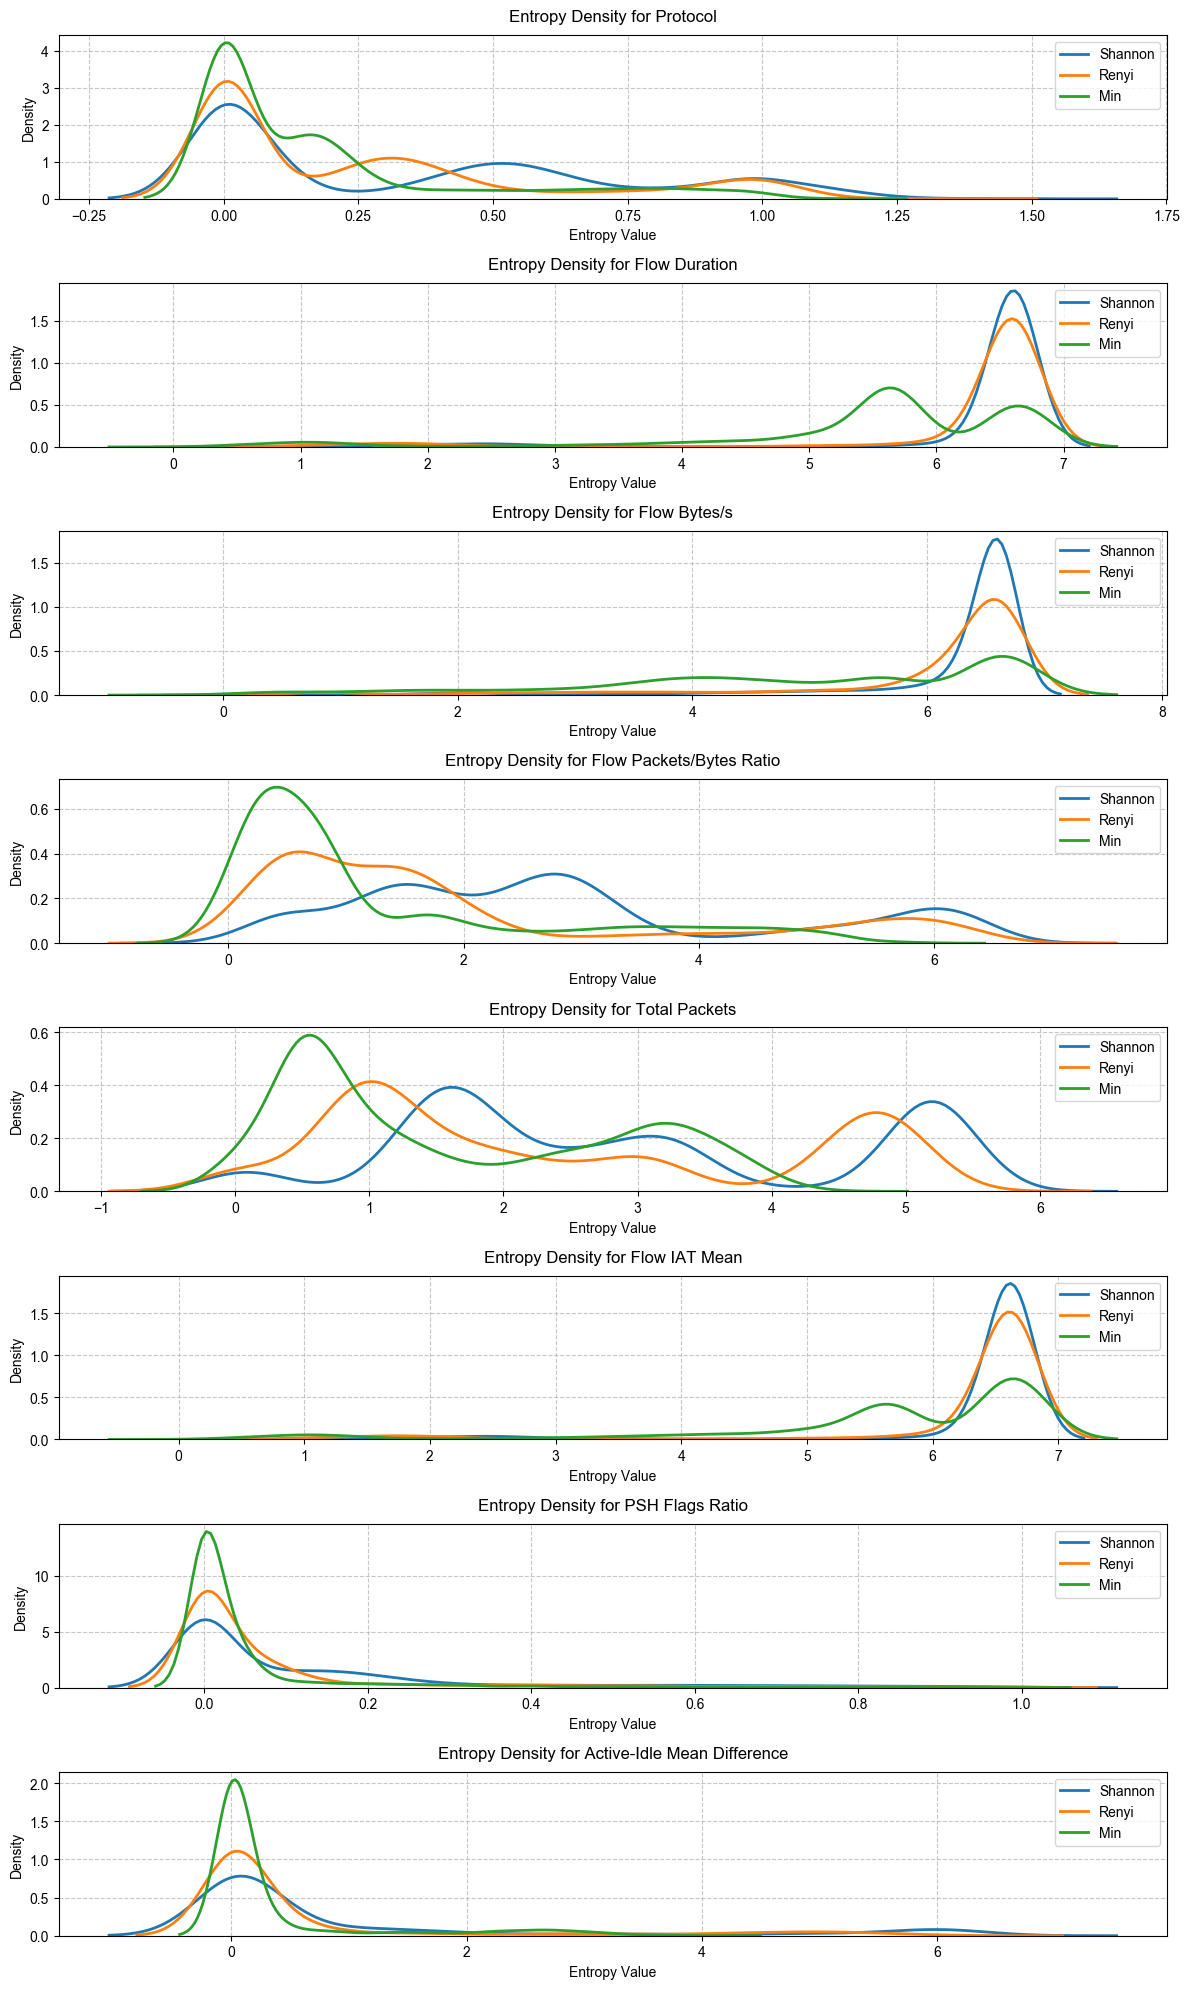

特徵向量總數: 431371


In [51]:

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from rich.console import Console
from rich.table import Table

# 初始化控制台
console = Console()

# 定義熵計算函數
def shannon_entropy(probabilities):
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

def renyi_entropy(probabilities, alpha=2):
    if alpha == 1:
        return shannon_entropy(probabilities)
    return (1 / (1 - alpha)) * np.log2(sum(p ** alpha for p in probabilities if p > 0))

def min_entropy(probabilities):
    return -np.log2(max(probabilities))

# 假設 df_combined 已定義，並包含所需特徵與標籤
# 定義用於計算熵的特徵
entropy_features = [
    "Protocol",
    "Flow Duration",
    "Flow Bytes/s",
    "Flow Packets/Bytes Ratio",
    "Total Packets",
    "Flow IAT Mean",
    "PSH Flags Ratio",
    "Active-Idle Mean Difference"
]

# 模擬分組：每 100 行作為一個窗口
df_combined['Temp Group'] = (df_combined.index // 100).astype(str)
grouped = df_combined.groupby('Temp Group')

# 計算每個組的熵特徵並生成特徵向量
entropy_vectors = []
group_entropy_values = {feat: {'Shannon': [], 'Renyi': [], 'Min': []} for feat in entropy_features}
for group_name, group_data in grouped:
    group_entropy = []
    for feature in entropy_features:
        value_counts = group_data[feature].value_counts(normalize=True)
        probabilities = value_counts.values
        if len(probabilities) < 2:  # 防止單一值導致熵無效
            probabilities = np.array([1.0])
        shannon = shannon_entropy(probabilities)
        renyi = renyi_entropy(probabilities, alpha=2)
        min_ent = min_entropy(probabilities)
        group_entropy.extend([shannon, renyi, min_ent])
        # 儲存熵值用於密度圖
        group_entropy_values[feature]['Shannon'].append(shannon)
        group_entropy_values[feature]['Renyi'].append(renyi)
        group_entropy_values[feature]['Min'].append(min_ent)
    # 為該組內的每行數據分配相同的熵特徵
    entropy_vectors.extend([group_entropy] * len(group_data))

# 轉換為 numpy 陣列並檢查形狀
feature_vectors = np.array(entropy_vectors)
if feature_vectors.shape[0] != len(df_combined):
    console.print(f"[bold red]錯誤：特徵向量行數 ({feature_vectors.shape[0]}) 與數據集行數 ({len(df_combined)}) 不匹配！[/]")
    raise ValueError("Feature vector length mismatch.")

# 顯示前幾個窗口的熵特徵範例
entropy_df = pd.DataFrame(
    feature_vectors,
    columns=[f"{feat}_{ent}" for feat in entropy_features for ent in ['Shannon', 'Renyi', 'Min']]
)
console.print("[bold cyan]Entropy Feature Vectors (First 2 Windows):[/]")
console.print(entropy_df.head(200))  # 顯示前兩個窗口（假設每個窗口 100 行）

# 繪製整體熵密度圖
plt.figure(figsize=(12, 20), dpi=100)
colors = {'Shannon': '#1f77b4', 'Renyi': '#ff7f0e', 'Min': '#2ca02c'}
for feature in entropy_features:
    plt.subplot(len(entropy_features), 1, entropy_features.index(feature) + 1)
    for ent_type in ['Shannon', 'Renyi', 'Min']:
        sns.kdeplot(
            group_entropy_values[feature][ent_type],
            label=ent_type,
            color=colors[ent_type],
            linewidth=2
        )
    plt.title(f'Entropy Density for {feature}', fontsize=12, pad=10)
    plt.xlabel('Entropy Value', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 輸出特徵向量總數
print(f"特徵向量總數: {len(feature_vectors)}")


In [3]:
import numpy as np
import time

# 測試資料
x = np.linspace(-10, 10, 100000)  # 大範圍測試

# 1️⃣ 泰勒展開
def exp2_taylor(x, n=10):
    y = np.ones_like(x)
    term = np.ones_like(x)
    ln2 = np.log(2)
    for i in range(1, n):
        term *= x * ln2 / i
        y += term
    return y

# 2️⃣ 牛頓法迭代
def exp2_newton(x, iters=5):
    y = np.ones_like(x) * np.exp2(x)  # 初值可以選 1 或 exp2(x) 的近似
    for _ in range(iters):
        y = y - (np.log2(y) - x) * y * np.log(2)
    return y

# 3️⃣ 分段多項式（range reduction + Taylor 5階）
def exp2_piecewise(x):
    ln2 = np.log(2)
    int_part = np.floor(x)
    frac_part = x - int_part
    # Taylor 展開前 5 項
    y_frac = 1 + frac_part*ln2 + (frac_part*ln2)**2/2 + (frac_part*ln2)**3/6 + (frac_part*ln2)**4/24
    return np.ldexp(y_frac.astype(np.float64), int_part.astype(np.int32))  # 2^int_part * y_frac

# 4️⃣ 浮點位 hack (approx)
# 4️⃣ 浮點位 hack (approx)
def exp2_fast(x):
    x = np.array(x, dtype=np.float32)
    y = x * (1 << 23) / np.log2(np.e) + (127 << 23)
    y = y.astype(np.uint32)           # 強制整數
    y = y.view(np.float32)            # reinterpret bits
    return y.astype(np.float64)       # 統一成 float64

# 5️⃣ Numpy 原生
def exp2_numpy(x):
    return 2**x

# 計時與誤差
methods = {
    "Taylor": exp2_taylor,
    "Newton": exp2_newton,
    "Piecewise": exp2_piecewise,
    "Fast Hack": exp2_fast,
    "Numpy": exp2_numpy
}

results = {}
ref = exp2_numpy(x)

for name, func in methods.items():
    start = time.time()
    y = func(x)
    end = time.time()
    results[name] = {
        "time": end - start,
        "max_error": np.max(np.abs(y - ref))
    }

# 顯示結果
print(f"{'Method':<12} {'Time (s)':<10} {'Max Error':<12}")
for name, info in results.items():
    print(f"{name:<12} {info['time']:<10.6f} {info['max_error']:<12.3e}")


Method       Time (s)   Max Error   
Taylor       0.003097   1.665e+02   
Newton       0.004684   1.137e-13   
Piecewise    0.003254   7.693e-01   
Fast Hack    0.000340   9.004e+02   
Numpy        0.000402   0.000e+00   


Running K-means clustering...

Running Hierarchical clustering...

Running GMM clustering...

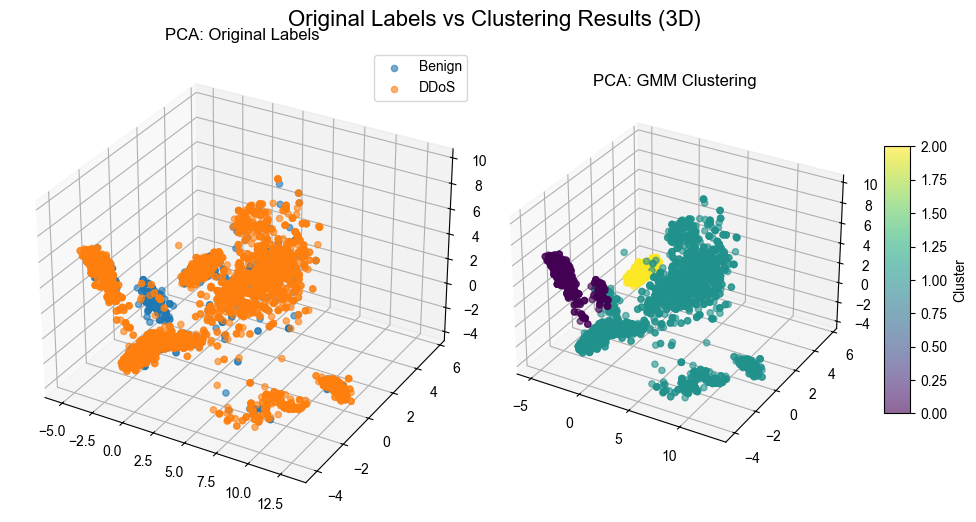

Clustering Metrics:

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Algorithm    ┃ Silhouette ┃ Davies-Bouldin ┃ Calinski-Harabasz ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ K-means      │     0.4657 │         0.9914 │         4376.6141 │
│ Hierarchical │     0.4661 │         0.9930 │         4354.3301 │
│ GMM          │     0.4192 │         0.8733 │         2802.0912 │
└──────────────┴────────────┴────────────────┴───────────────────┘

Analyzing K-means cluster label distribution:

┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ Cluster ┃ Benign Count ┃ DDoS Count ┃ Total Count ┃ Benign % ┃ DDoS % ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│    0    │          887 │       2905 │        3792 │   23.39% │ 76.61% │
│    1    │          681 │       1544 │        2225 │   30.61% │ 69.39% │
│    2    │          246 │       1737 │        1983 │   12.41% │ 87.59% │
└─────────┴──────────────┴────────────┴─────────────┴──────────┴────────┘

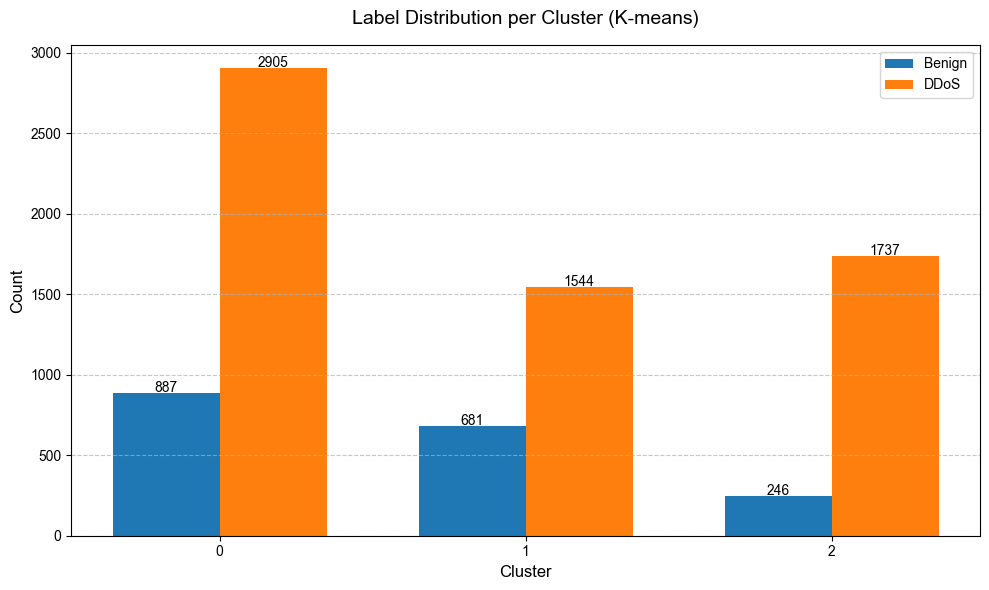

K-means Cluster Characteristics:

Cluster 0: Mixed (Benign 23.39%, DDoS 76.61%, 3792 samples)

Cluster 1: Mixed (Benign 30.61%, DDoS 69.39%, 2225 samples)

Cluster 2: Likely DDoS (DDoS 87.59%, 1983 samples)

Analyzing Hierarchical cluster label distribution:

┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ Cluster ┃ Benign Count ┃ DDoS Count ┃ Total Count ┃ Benign % ┃ DDoS % ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│    0    │          256 │       1780 │        2036 │   12.57% │ 87.43% │
│    1    │          878 │       2862 │        3740 │   23.48% │ 76.52% │
│    2    │          680 │       1544 │        2224 │   30.58% │ 69.42% │
└─────────┴──────────────┴────────────┴─────────────┴──────────┴────────┘

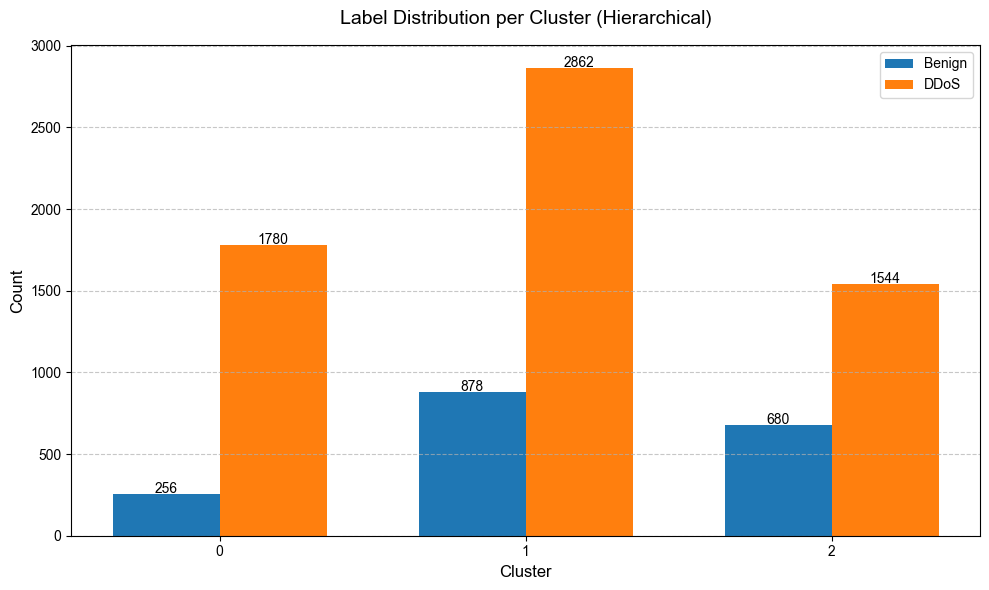

Hierarchical Cluster Characteristics:

Cluster 0: Likely DDoS (DDoS 87.43%, 2036 samples)

Cluster 1: Mixed (Benign 23.48%, DDoS 76.52%, 3740 samples)

Cluster 2: Mixed (Benign 30.58%, DDoS 69.42%, 2224 samples)

Analyzing GMM cluster label distribution:

┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ Cluster ┃ Benign Count ┃ DDoS Count ┃ Total Count ┃ Benign % ┃ DDoS % ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│    0    │          216 │        682 │         898 │   24.05% │ 75.95% │
│    1    │          919 │       3964 │        4883 │   18.82% │ 81.18% │
│    2    │          679 │       1540 │        2219 │   30.60% │ 69.40% │
└─────────┴──────────────┴────────────┴─────────────┴──────────┴────────┘

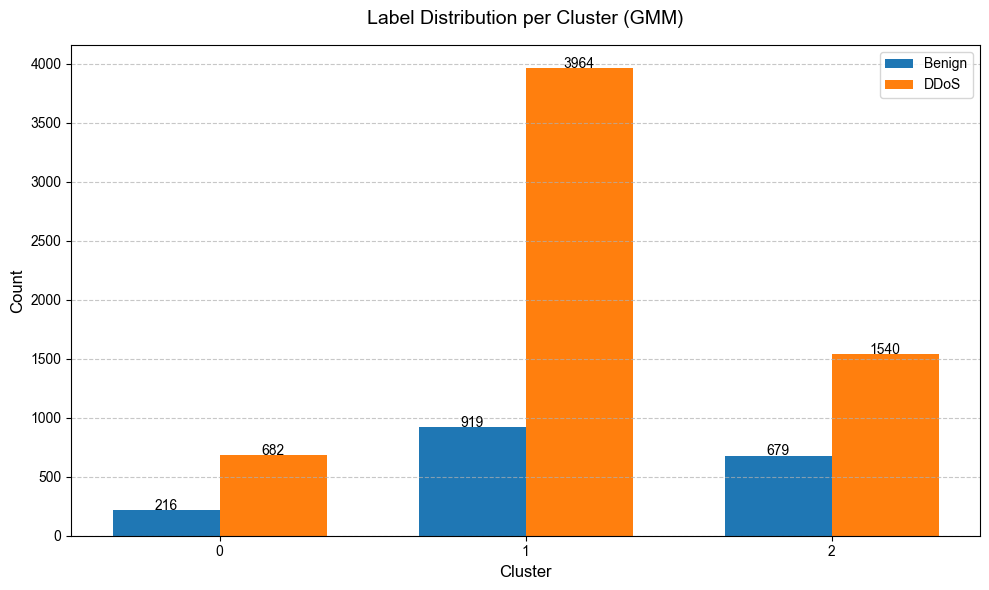

GMM Cluster Characteristics:

Cluster 0: Mixed (Benign 24.05%, DDoS 75.95%, 898 samples)

Cluster 1: Likely DDoS (DDoS 81.18%, 4883 samples)

Cluster 2: Mixed (Benign 30.60%, DDoS 69.40%, 2219 samples)

In [52]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
from sklearn.manifold import TSNE
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D  # 這行不能少！

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# Initialize console for rich output
console = Console()

# 假設原始資料為 df_combined，feature_vectors 是已經轉成特徵矩陣的部分
from sklearn.model_selection import train_test_split
df_processed = df_combined.copy()
n_clusters = 3
# 目標樣本數
N = 8000

# 分層抽樣，確保保留標籤
if 'Label' in df_processed.columns and df_processed['Label'].nunique() > 1:
    df_sampled, _, entropy_sampled, _ = train_test_split(
        df_processed,
        entropy_vectors,
        train_size=N,
        stratify=df_processed['Label'],
        random_state=42
    )
    df_processed = df_sampled.reset_index(drop=True)
    entropy_vectors = entropy_sampled
else:
    console.print("[bold red]❌ Label 欄位不存在或只有單一類別，無法分層抽樣！[/]")
    exit()

# 使用熵特徵進行分群
clustering_vectors = entropy_vectors

# Dimensionality reduction
dim_reduction_methods = {
    'PCA': PCA(n_components=3),
}

# Apply dimensionality reduction
dim_reduction_results = {
    name: model.fit_transform(clustering_vectors)
    for name, model in dim_reduction_methods.items()
}

# Plot original labels vs clustering results (3D)
def plot_label_vs_cluster_3d():
    if 'Label' not in df_processed.columns or not df_processed['Label'].isin(['Benign', 'DDoS']).any():
        console.print("[bold red]No valid 'Label' column or labels (Benign/DDoS) found.[/]")
        return

    label_colors = {'Benign': '#1f77b4', 'DDoS': '#ff7f0e'}
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle('Original Labels vs Clustering Results (3D)', fontsize=16, y=0.92)

    for idx, (method, result) in enumerate(dim_reduction_results.items()):
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        for label in ['Benign', 'DDoS']:
            mask = df_processed['Label'] == label
            ax1.scatter(result[mask, 0], result[mask, 1], result[mask, 2], 
                        c=label_colors[label], label=label, alpha=0.6)
        ax1.set_title(f'{method}: Original Labels')
        ax1.legend()
        ax1.grid(True)

        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        scatter = ax2.scatter(result[:, 0], result[:, 1], result[:, 2],
                              c=cluster_labels['GMM'], cmap='viridis', alpha=0.6)
        ax2.set_title(f'{method}: GMM Clustering')
        fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=10, label='Cluster')
        ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Clustering algorithms
clustering_algorithms = {
    'K-means': KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42
    ),
    'Hierarchical': AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage='ward',
        compute_full_tree=False,
        distance_threshold=None
    ),
    'GMM': GaussianMixture(
        n_components=n_clusters,
        covariance_type='full',
        max_iter=100,
        n_init=1,
        random_state=42
    )
}

# Store clustering results and metrics
results = {}
cluster_labels = {}

# Run clustering and evaluate
for name, algo in clustering_algorithms.items():
    console.print(f"[bold cyan]Running {name} clustering...[/]")
    if name == 'GMM':
        algo.fit(clustering_vectors)
        labels = algo.predict(clustering_vectors)
    else:
        labels = algo.fit_predict(clustering_vectors)
    
    cluster_labels[name] = labels
    n_clusters = len(np.unique(labels[labels != -1]))
    
    metrics = {}
    if n_clusters >= 2:
        metrics['Silhouette'] = silhouette_score(clustering_vectors, labels, metric='euclidean')
        metrics['Davies-Bouldin'] = davies_bouldin_score(clustering_vectors, labels)
        metrics['Calinski-Harabasz'] = calinski_harabasz_score(clustering_vectors, labels)
    else:
        console.print(f"[bold yellow]Warning: {name} has {n_clusters} clusters, skipping metrics.[/]")
        metrics = {'Silhouette': np.nan, 'Davies-Bouldin': np.nan, 'Calinski-Harabasz': np.nan}
    
    results[name] = metrics

# Display clustering metrics table
def display_metrics_table():
    table = Table(show_header=True, header_style="bold magenta")
    table.add_column("Algorithm", style="dim")
    for metric in ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']:
        table.add_column(metric, justify="right")
    
    for name, metrics in results.items():
        table.add_row(
            name,
            *[f"{metrics[metric]:.4f}" if not np.isnan(metrics[metric]) else "N/A"
              for metric in ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']]
        )
    
    console.print("[bold cyan]Clustering Metrics:[/]")
    console.print(table)

# Label analysis
def analyze_labels():
    if 'Label' not in df_processed.columns or not df_processed['Label'].isin(['Benign', 'DDoS']).any():
        console.print("[bold red]No valid 'Label' column or labels (Benign/DDoS) found.[/]")
        return

    df_valid = df_processed[df_processed['Label'].isin(['Benign', 'DDoS'])].copy()
    
    for name, labels in cluster_labels.items():
        console.print(f"[bold cyan]Analyzing {name} cluster label distribution:[/]")
        df_valid['Cluster'] = labels[df_valid.index]
        
        cluster_counts = df_valid.groupby('Cluster')['Label'].value_counts().unstack(fill_value=0)
        cluster_counts['Total'] = cluster_counts.sum(axis=1)
        cluster_counts['Benign %'] = cluster_counts['Benign'] / cluster_counts['Total'] * 100
        cluster_counts['DDoS %'] = cluster_counts['DDoS'] / cluster_counts['Total'] * 100
        
        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Cluster", style="dim", justify="center")
        for col in ['Benign Count', 'DDoS Count', 'Total Count', 'Benign %', 'DDoS %']:
            table.add_column(col, justify="right")
        
        for cluster in cluster_counts.index:
            row = cluster_counts.loc[cluster]
            table.add_row(
                str(cluster),
                str(int(row.get('Benign', 0))),
                str(int(row.get('DDoS', 0))),
                str(int(row['Total'])),
                f"{row['Benign %']:.2f}%",
                f"{row['DDoS %']:.2f}%"
            )
        console.print(table)
        
        plt.figure(figsize=(10, 6), dpi=100)
        clusters = cluster_counts.index
        bar_width = 0.35
        x = np.arange(len(clusters))
        
        plt.bar(x - bar_width/2, cluster_counts['Benign'], bar_width, label='Benign', color='#1f77b4')
        plt.bar(x + bar_width/2, cluster_counts['DDoS'], bar_width, label='DDoS', color='#ff7f0e')
        plt.xlabel('Cluster', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.title(f'Label Distribution per Cluster ({name})', fontsize=14, pad=15)
        plt.xticks(x, [f'{"Noise" if c == -1 else c}' for c in clusters])
        plt.legend(fontsize=10)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        
        for i, count in enumerate(cluster_counts['Benign']):
            plt.text(i - bar_width/2, count + 5, str(int(count)), ha='center', fontsize=10)
        for i, count in enumerate(cluster_counts['DDoS']):
            plt.text(i + bar_width/2, count + 5, str(int(count)), ha='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        console.print(f"[bold cyan]{name} Cluster Characteristics:[/]")
        for cluster in cluster_counts.index:
            row = cluster_counts.loc[cluster]
            benign_pct, ddos_pct, total = row['Benign %'], row['DDoS %'], row['Total']
            cluster_name = 'Noise' if cluster == -1 else f'Cluster {cluster}'
            
            if ddos_pct > 80:
                console.print(f"[bold green]{cluster_name}[/]: Likely DDoS (DDoS {ddos_pct:.2f}%, {int(total)} samples)")
            elif benign_pct > 80:
                console.print(f"[bold green]{cluster_name}[/]: Likely Benign (Benign {benign_pct:.2f}%, {int(total)} samples)")
            else:
                console.print(f"[bold yellow]{cluster_name}[/]: Mixed (Benign {benign_pct:.2f}%, DDoS {ddos_pct:.2f}%, {int(total)} samples)")

# Execute pipeline
plot_label_vs_cluster_3d()
display_metrics_table()
analyze_labels()

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dhoogla/cicddos2019")

print("Path to dataset files:", path)

Path to dataset files: /Users/hungwei/.cache/kagglehub/datasets/dhoogla/cicddos2019/versions/3


In [17]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from mambapy.mamba import Mamba, MambaConfig
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hyperparameters
seq_len = 20
batch_size = 64
num_epochs = 10
learning_rate = 1e-4  # Reduced learning rate
base_path = '/Users/hungwei/.cache/kagglehub/datasets/dhoogla/cicddos2019/versions/3'

# MambaDDoSDetector
class MambaDDoSDetector(nn.Module):
    def __init__(self, input_dim, seq_len, d_state=32, d_conv=4, expand=1):
        super(MambaDDoSDetector, self).__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, input_dim) * 0.02)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len + 1, input_dim) * 0.02)
        config = MambaConfig(d_model=input_dim, n_layers=2, d_state=d_state, expand_factor=expand)
        self.mamba_blocks = nn.ModuleList([Mamba(config) for _ in range(2)])  # Reduced blocks
        self.classifier = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        cls_tok = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tok, x], dim=1)
        x = x + self.pos_embedding
        for block in self.mamba_blocks:
            x = block(x)
        cls_out = x[:, 0, :]
        logits = self.classifier(cls_out)
        return logits

# Load and preprocess data
file_names = ['LDAP-training.parquet','MSSQL-training.parquet']
dfs = [pd.read_parquet(os.path.join(base_path, fn)) for fn in file_names]
df = pd.concat(dfs, ignore_index=True)
df.columns = df.columns.str.strip()
df['Label'] = df['Label'].apply(lambda x: 'DDoS' if x != 'Benign' else x)
df['Label'] = df['Label'].map({'Benign': 0, 'DDoS': 1})

# Check raw data
print("NaN in df:", df.isna().sum().sum())
df = df.replace([np.inf, -np.inf], np.nan).dropna()
print("After cleaning, NaN in df:", df.isna().sum().sum())
print("Unique labels:", df['Label'].unique())

# Standardize features
features = df.columns.drop('Label')
features = features[df[features].var() > 0]
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
X = df[features].values
y = df['Label'].values
print("NaN in X:", np.any(np.isnan(X)))
print("Inf in X:", np.any(np.isinf(X)))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create sequences
def create_sequences(X_arr, y_arr, seq_len):
    if np.any(np.isnan(X_arr)) or np.any(np.isinf(X_arr)):
        raise ValueError("X_arr contains NaN or Inf")
    if np.any(np.isnan(y_arr)) or np.any(np.isinf(y_arr)):
        raise ValueError("y_arr contains NaN or Inf")
    X_seq, y_seq = [], []
    for i in range(len(X_arr) - seq_len + 1):
        X_seq.append(X_arr[i : i + seq_len])
        y_seq.append(y_arr[i + seq_len - 1])
    X_np = np.stack(X_seq, axis=0).astype(np.float32)
    y_np = np.array(y_seq, dtype=np.float32)
    if np.any(np.isnan(X_np)) or np.any(np.isinf(X_np)):
        raise ValueError("X_np contains NaN or Inf")
    if np.any(np.isnan(y_np)) or np.any(np.isinf(y_np)):
        raise ValueError("y_np contains NaN or Inf")
    return torch.from_numpy(X_np), torch.from_numpy(y_np)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_len)
print("X_train_seq shape:", X_train_seq.shape)
print("NaN in X_train_seq:", torch.any(torch.isnan(X_train_seq)))

# DataLoader
train_ds = TensorDataset(X_train_seq, y_train_seq)
test_ds = TensorDataset(X_test_seq, y_test_seq)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Model and training
device = torch.device("cpu")  # Test on CPU first
input_dim = X_train.shape[1]
model = MambaDDoSDetector(input_dim=input_dim, seq_len=seq_len)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        if torch.isnan(loss):
            print("NaN loss detected")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch}/{num_epochs}  Loss: {avg_loss:.4f}')

# Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        outputs = model(X_batch)
        preds = (outputs > 0).float()  # Adjusted threshold
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

NaN in df: 0
After cleaning, NaN in df: 0
Unique labels: [1 0]
NaN in X: False
Inf in X: False
X_train_seq shape: torch.Size([14132, 20, 65])
NaN in X_train_seq: tensor(False)
Epoch 1/10  Loss: 0.6757
Epoch 2/10  Loss: 0.6745
Epoch 3/10  Loss: 0.6745
Epoch 4/10  Loss: 0.6746
Epoch 5/10  Loss: 0.6745
Epoch 6/10  Loss: 0.6744
Epoch 7/10  Loss: 0.6744
Epoch 8/10  Loss: 0.6743
Epoch 9/10  Loss: 0.6744
Epoch 10/10  Loss: 0.6744
Test Accuracy: 58.94%


In [15]:
import torch
from mambapy.mamba import Mamba, MambaConfig

config = MambaConfig(d_model=16, n_layers=2)
model = Mamba(config)

B, L, D = 2, 64, 16
x = torch.randn(B, L, D)
y = model(x)

assert y.shape == x.shape

In [ ]:
# 輸入資料
total_data_points = 2_830_743    # 總資料筆數
window_size = 100                # 每個 window 的大小
total_time_seconds = 73          # 總處理時間（秒）

# 計算 window 數
num_windows = total_data_points // window_size

# 每個 window 花費的時間（秒）
time_per_window_sec = total_time_seconds / num_windows

# 換算成奈秒
time_per_window_ns = time_per_window_sec * 1e6

# 印出結果
print(f"Window 數量: {num_windows}")
print(f"每個 window 平均耗時：{time_per_window_sec:.6f} 秒")
print(f"每個 window 平均耗時：{time_per_window_ns:.0f} 奈秒")


Window 數量: 127946
每個 window 平均耗時：0.000141 秒
每個 window 平均耗時：141 奈秒


In [ ]:
import pandas as pd

# 方法組合與時間（奈秒）
methods = [
    # ("GMM 單核 + 特徵並行", 5_831_764),
    # ("GMM 並行 + C++ 並行", 3_532_786),
    ("GMM 並行 + C++(AVX) + 控制", 12794627),
]

# 推論後端
backends = {
    "Transformer": 12_700,
    "Mamba": 834
}

# 組合計算並轉成微秒
data = []
for method, entropy_plus_cluster_ns in methods:
    for backend_name, backend_ns in backends.items():
        entropy_ns = 112  # 固定值（你原本的 baseline entropy 是 0.112 us）
        cluster_ns = entropy_plus_cluster_ns - entropy_ns  # 分開 entropy 與 clustering
        total_ns = entropy_ns + cluster_ns + backend_ns
        data.append({
            "Method": method,
            "backend_name": backend_name,
            "Entropy (us)": round(entropy_ns / 1000, 3),
            "Clustering (us)": round(cluster_ns / 1000, 3),
            "Backend Inference (us)": round(backend_ns / 1000, 3),
            "Total (us)": round(total_ns / 1000, 3)
        })

# 製成 DataFrame
df = pd.DataFrame(data)
print(df.to_string(index=False))


                Method backend_name  Entropy (us)  Clustering (us)  Backend Inference (us)  Total (us)
GMM 並行 + C++(AVX) + 控制  Transformer         0.112         2579.851                  12.700    2592.663
GMM 並行 + C++(AVX) + 控制        Mamba         0.112         2579.851                   0.834    2580.797
